# Sensitivity analysis

## Biblioteka SALib i funkcja Ishigami

In [26]:
# import libraries
%load_ext autotime
from SALib.plotting.bar import plot as barplot
from SALib.sample import saltelli, fast_sampler, morris as morris_sample
from SALib.analyze import sobol, fast, morris
from SALib.test_functions import Ishigami
import numpy as np
import math

In [27]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [28]:
ś

In [29]:
# Evaluate Ishigami model
Y_Ishigami_sobol = Ishigami.evaluate(param_values_sobol)

In [30]:
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.063735 0.560137 0.082982
x2 0.447767 0.056246 0.438722 0.042792
x3 -0.004255 0.054337 0.242845 0.026886

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.077135
x1 x3 0.251526 0.104746
x2 x3 -0.009954 0.068216


__Zadanie 1:__ Użyj innych algorytmów do tworzenia próbek i analizowania modelu dostępnych w SALib, przeanalizuj otrzymane wyniki a także czas wykonania algorytmów analizujących. - https://salib.readthedocs.io/en/latest/api.html. Wskazówka: dla metody fast należy użyć samplera fast_sampler, a dla metody morris samplera morris_sample.

In [31]:
#FAST - Fourier Amplitude Sensitivity Test
X_FAST = fast_sampler.sample(problem, 1000)

In [32]:
Y_FAST = Ishigami.evaluate(X_FAST)

In [33]:
Si_FAST = fast.analyze(problem, Y_FAST, print_to_console=True)

Parameter First Total
x1 0.322092 0.576890
x2 0.442475 0.469378
x3 0.000000 0.239276


In [34]:
#Samples for morris test
X_morris = morris_sample.sample(problem, 1000, num_levels=4)

In [35]:
Y_morris = Ishigami.evaluate(X_morris)

In [36]:
Si = morris.analyze(problem, X_morris, Y_morris, conf_level=0.95, print_to_console=True, num_levels=4)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  7.354      7.354           0.392      6.242
x2                                  7.875     -0.047           0.000      7.879
x3                                  6.424      0.175           0.396      8.963


## Użycie własnego modelu w bibliotece SALib

Poniżej został pokazany przykład badania wrażliwości modelu Net Present Value (https://www.wallstreetmojo.com/net-present-value-npv-formula). Badamy zrażliwość modelu na początkowy koszt inwestycji i na wpływy środków w czasie (zakładamy stały dopływ środków). 

In [12]:
def evaluate(values):
    Y = np.zeros([values.shape[0]])
    t = 5
    R = 0.1
    
    for i, X in enumerate(values):
        sum = 0
        for i in range(t):
            sum += X[0]/((1 + R) ** i - X[1])
        Y[i] = sum
    return Y

# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['x1', 'x2',],
    'bounds': [[10, 100],
               [10, 1000]]
}
# Generate samples for SOBOL
param_values_sobol = saltelli.sample(problem, 1000)
# Evaluate Ishigami model
Y_Ishigami_sobol = evaluate(param_values_sobol)
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
x1 -0.000004 0.000004 0.000005 0.000005
x2 -0.000008 0.000008 0.000024 0.000023

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 2.024885 1.936497


__Zadanie 2:__ Zaimplementować własny model fizyczny/matematyczny/biznesowy i zbadać jego wrażliwość. Np: Dividend discount model (https://en.wikipedia.org/wiki/Dividend_discount_model)

## Predator-prey model

In [13]:
from scipy import integrate
import pylab as p

In [14]:
simulationSteps = 100
startSimulationTime = 0
endSimulationTime = 15
sampleNum = 100

In [15]:
class PredatorPreyModel:
    simulationsResults = []
    initialPredatorPopulation = 10
    initialPreyPopulation = 5
    alfa = 1.
    beta = 0.2
    gamma = 1.5
    delta = 0.75
    
    def dX_dt(self, X, t):
          return np.array([ self.alfa*X[0] - self.beta*X[0]*X[1] ,
                         -self.gamma*X[1] + self.delta*self.beta*X[0]*X[1] ])

    def setupModel(self, values):
        for i, X in enumerate(values):
            # prey and pred populations at beginning
            predatorPreyPopulations = np.array([self.initialPredatorPopulation, self.initialPreyPopulation])
            t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps) 
            self.alfa = X[0]
            self.beta = X[1]

            # calculate predator-prey 
            PPPolulationsAtStep, infodict = integrate.odeint(self.dX_dt, predatorPreyPopulations, t, full_output=True)
            self.simulationsResults.append(PPPolulationsAtStep)

    def getArrayOfModelValues(self, step):
        Y = np.zeros([len(self.simulationsResults)])
        for i in range(len(self.simulationsResults)):
            Y[i] = self.simulationsResults[i][step][0] # [0] for predators, [1] for preys
        return Y


In [16]:
class ModifiedPredatorPreyModel:
    simulationsResults = []
    initialPredatorPopulation = 10
    initialPreyPopulation = 5
    alfa = 1.
    beta = 0.2
    gamma = 1.5
    delta = 0.75
    K = 10
    
    def dX_dt(self, X, t):
          return np.array([ self.alfa*X[0]*(1-X[0]/self.K) - self.beta*X[0]*X[1] ,
                         -self.gamma*X[1] + self.delta*self.beta*X[0]*X[1] ])

    def setupModel(self, values):
        for i, X in enumerate(values):
            # prey and pred populations at beginning
            predatorPreyPopulations = np.array([self.initialPredatorPopulation, self.initialPreyPopulation])
            t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps) 
            self.alfa = X[0] # !!! self.alfa, self.beta, self.gamma, self.delta
            self.beta = X[1] # !!!

            # calculate predator-prey 
            PPPolulationsAtStep, infodict = integrate.odeint(self.dX_dt, predatorPreyPopulations, t, full_output=True)
            self.simulationsResults.append(PPPolulationsAtStep)

    def getArrayOfModelValues(self, step):
        Y = np.zeros([len(self.simulationsResults)])
        for i in range(len(self.simulationsResults)):
            Y[i] = self.simulationsResults[i][step][0] # [0] for predators, [1] for preys !!!
        return Y

In [17]:
# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['alfa', 'beta'],
    'bounds': [[0.75, 1.25],
               [0.15, 0.25]]
}

In [18]:
# Generate samples
param_values = saltelli.sample(problem, sampleNum)

In [23]:
# Calculate sensivitness for evry simulation step
sensitivity = []
alfaAndBetaSensitivity = []
alfaSensitivity = []
betaSensitivity = []

model = PredatorPreyModel() # ModifiedPredatorPreyModel() !!!
model.setupModel(param_values)

for i in range(simulationSteps):
    # get array of model values at time step 'i'
    Y = model.getArrayOfModelValues(i)
    # analyze these values using sobol method
    Si = sobol.analyze(problem, Y, print_to_console=False)

    alfaSensitivity.append(Si['S1'][0])
    betaSensitivity.append(Si['S1'][1])
    alfaAndBetaSensitivity.append(Si['S2'][0,1])

Text(0.5, 1.0, 'Sensitivness of alfa & beta in time')

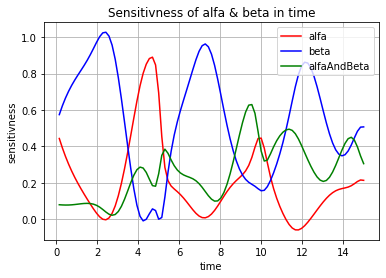

In [24]:
# plot results
t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps)
f1 = p.figure()
p.plot(t, alfaSensitivity, 'r-', label='alfa')
p.plot(t, betaSensitivity, 'b-', label='beta')
p.plot(t, alfaAndBetaSensitivity, 'g-', label='alfaAndBeta')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('sensitivness')
p.title('Sensitivness of alfa & beta in time for predator')

__Zadanie 3:__ Zbadać wrażliwość zmiennych alfa, beta gamma, delta modelu predator-prey lub zmodyfikowanego model predator-prey. Należy zbadać to dla predator jak i dla prey.